In [1]:
import time
import os
import sys

import numpy as np
import matplotlib
matplotlib.use('nbagg')
#from matplotlib import style
#style.use('ggplot')
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import stats
from astropy.io import fits
from mmtwfs.wfs import *
from mmtwfs.zernike import ZernikeVector
from mmtwfs.telescope import MMT
import poppy

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append("/Users/tim/src/cwfs/python")
%cd /Users/tim/MMT/cwfs/

/Users/tim/MMT/cwfs


In [4]:
from lsst.cwfs.instrument import Instrument
from lsst.cwfs.algorithm import Algorithm
from lsst.cwfs.image import Image, readFile
import lsst.cwfs.plots as plots

In [5]:
p1000_set1_files = [
    "sog_ff_cal_img_2017.1207.083225.fits",
    "sog_ff_cal_img_2017.1207.083329.fits",
    "sog_ff_cal_img_2017.1207.083411.fits"
]
m1000_set1_files = [
    "sog_ff_cal_img_2017.1207.083508.fits",
    "sog_ff_cal_img_2017.1207.083545.fits",
    "sog_ff_cal_img_2017.1207.083625.fits"
]
m1000_set2_files = [
    "sog_ff_cal_img_2017.1207.083737.fits",
    "sog_ff_cal_img_2017.1207.083813.fits",
    "sog_ff_cal_img_2017.1207.083848.fits"
]
p1000_set2_files = [
    "sog_ff_cal_img_2017.1207.083948.fits",
    "sog_ff_cal_img_2017.1207.084024.fits",
    "sog_ff_cal_img_2017.1207.084059.fits"
]

In [88]:
p1000_set1_data = []
for f in p1000_set1_files:
    hdu = fits.open(f)
    data = hdu[1].data
    header = hdu[1].header
    p1000_set1_data.append(data)
p1000_set1_data = np.array(p1000_set1_data)

p1000_set2_data = []
for f in p1000_set2_files:
    hdu = fits.open(f)
    data = hdu[1].data
    header = hdu[1].header
    p1000_set2_data.append(data)
p1000_set2_data = np.array(p1000_set2_data)
    
m1000_set1_data = []
for f in m1000_set1_files:
    hdu = fits.open(f)
    data = hdu[1].data
    header = hdu[1].header
    m1000_set1_data.append(data)
m1000_set1_data = np.array(m1000_set1_data)

m1000_set2_data = []
for f in m1000_set2_files:
    hdu = fits.open(f)
    data = hdu[1].data
    header = hdu[1].header
    m1000_set2_data.append(data)
m1000_set2_data = np.array(m1000_set2_data)

#### Note: at a rotator angle of 0 North is to the right and West is down in sky motion.  With cassegrain flip, the pupil north is then to the left and east is up. This means the wavefront needs to be derotated by -90 deg - rotator angle.

<IPython.core.display.Javascript object>


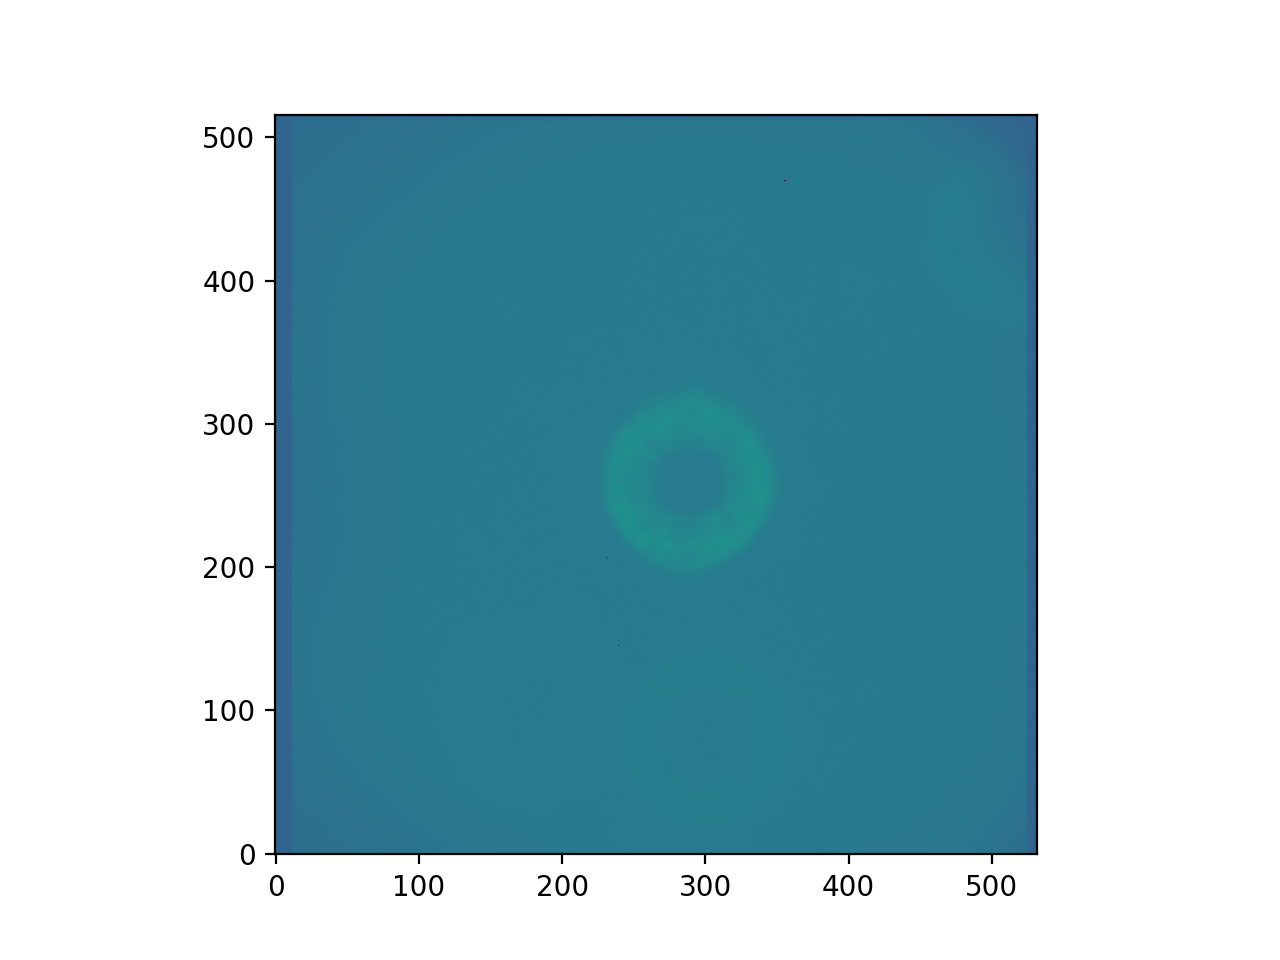

In [7]:
plt.imshow(p1000_set2_data[0], origin="lower")
plt.show()

In [8]:
size = 90
inner = 15
y, x = np.ogrid[-size:size, -size:size]
mask_in = x*x + y*y <= inner*inner
mask_out = x*x + y*y >= size*size
p1000_set1_med = np.median(p1000_set1_data, axis=0)[260-size:260+size,289-size:289+size]
p1000_set2_med = np.median(p1000_set2_data, axis=0)[260-size:260+size,289-size:289+size]
m1000_set1_med = np.median(m1000_set1_data, axis=0)[260-size:260+size,289-size:289+size]
m1000_set2_med = np.median(m1000_set2_data, axis=0)[260-size:260+size,289-size:289+size]
for im in [p1000_set1_med, p1000_set2_med, m1000_set1_med, m1000_set2_med]:
    im -= np.median(im[:,:10])
    im[im < 0] = 0.
#    im[mask_in] = 0.
#|    im[mask_out] = 0.

<IPython.core.display.Javascript object>


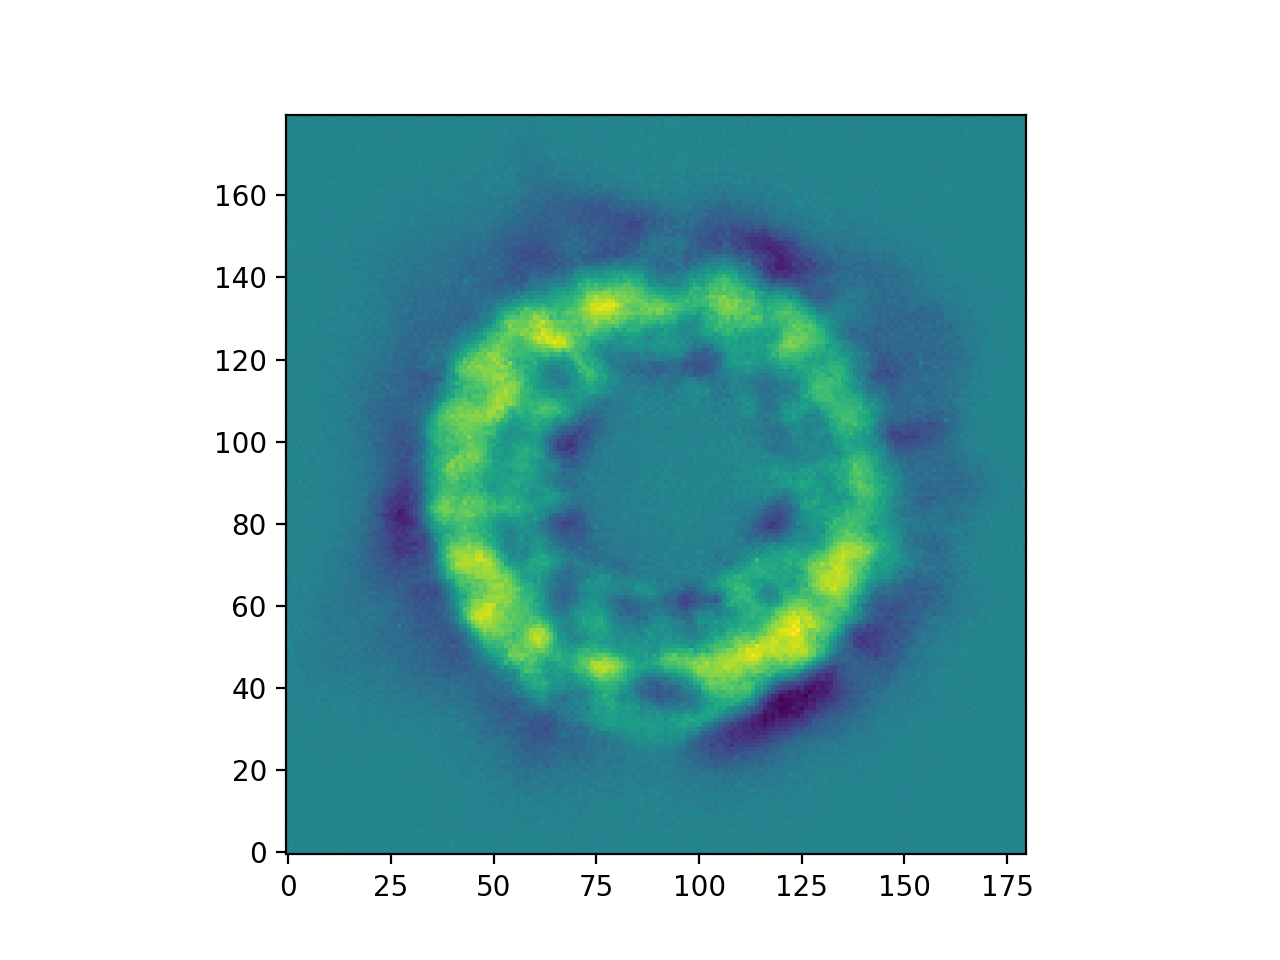

(180, 180)

In [9]:
plt.imshow(p1000_set1_med - m1000_set1_med, origin="lower")
plt.show()
p1000_set2_med.shape

In [10]:
set1 = p1000_set1_med - m1000_set1_med
set2 = p1000_set2_med - m1000_set2_med

In [11]:
fits.writeto("p1000_s1.fits", p1000_set1_med, overwrite=True)
fits.writeto("p1000_s2.fits", p1000_set2_med, overwrite=True)
fits.writeto("m1000_s1.fits", m1000_set1_med, overwrite=True)
fits.writeto("m1000_s2.fits", m1000_set2_med, overwrite=True)

In [89]:
fieldXY = [0., 0.]
I1 = Image(readFile("p1000_s2.fits"), fieldXY, Image.INTRA)
I2 = Image(readFile("m1000_s2.fits"), fieldXY, Image.EXTRA)

<IPython.core.display.Javascript object>


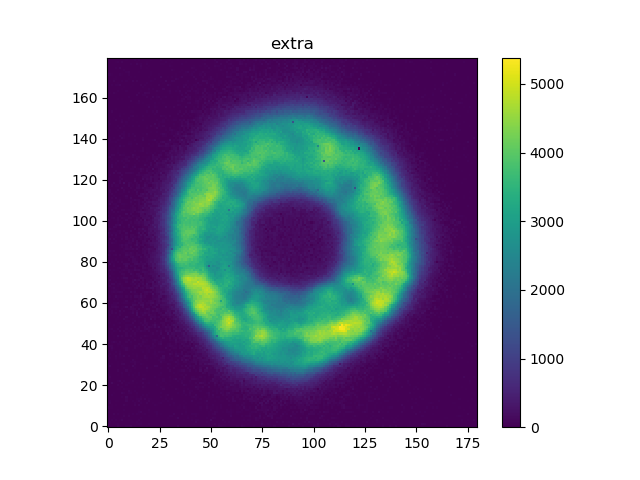

In [74]:
plots.plotImage(I1.image, 'extra')

In [75]:
mmt = Instrument('mmto', I1.sizeinPix)

In [76]:
algo = Algorithm('exp', mmt, 3)

In [77]:
algo.runIt(mmt, I1, I2, 'onAxis')

resetting images: I1 and I2
imageCoCenter: (x1,y1)=(   90.19,   90.05)

imageCoCenter: (x1,y1)=(   92.27,   89.71)

itr = 0, z4-z22
[ 127.  286. -186.  -92.  163.  166.  -20.  289.  103.  -88.  -28.   61.
  -32.    8.   -3.  -40.  -18.   19.  -87.]
itr = 1, z4-z22
[ 145.  290. -186.  -95.  152.  165.  -19.  291.  103.  -87.  -26.   60.
  -18.   13.   -3.  -39.  -17.   18.  -84.]
itr = 2, z4-z22
[ 154.  279. -196.  -93.  166.  158.  -25.  292.  105.  -88.  -28.   63.
  -34.    7.   -3.  -41.  -17.   22.  -82.]
itr = 3, z4-z22
[ 162.  322. -225.  -96.  155.  155.  -28.  293.  101.  -82.  -28.   61.
  -19.   13.   -3.  -40.  -17.   21.  -81.]
itr = 4, z4-z22
[ 165.  337. -246.  -99.  166.  153.  -31.  294.  100.  -80.  -29.   61.
  -34.   16.   -3.  -40.  -18.   21.  -81.]
itr = 5, z4-z22
[ 305.  284. -164.  -89.  147.  190.  -18.  326.  110.  -85.  -22.   55.
  -18.   15.   -6.  -34.  -14.   18.  -56.]
itr = 6, z4-z22
[ 399.  243. -132. -105.  143.  191.  -17.  345.  119.  -89.  -23.   5

In [78]:
print(algo.zer4UpNm)

[ 436.69199704  182.25239859  -47.20259279 -107.65197532  137.82677531
  132.18168194   -6.70080441  354.6835891   127.21571353  -93.58404594
  -23.4792947    74.94949742  -11.08540967   24.80174217   -7.98889628
  -42.45187219  -15.56492415   23.61636513  -32.04494674]


<IPython.core.display.Javascript object>


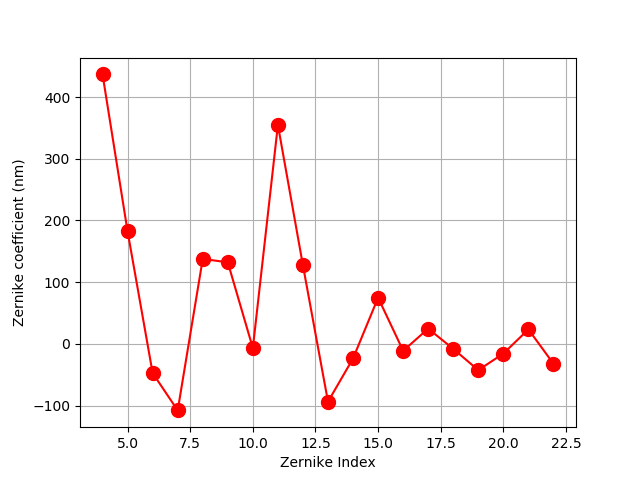

In [79]:
plots.plotZer(algo.zer4UpNm, 'nm')

In [85]:
zv = ZernikeVector()
zv.from_array(algo.zer4UpNm, modestart=4, normalized=True)
zv.denormalize()

<IPython.core.display.Javascript object>


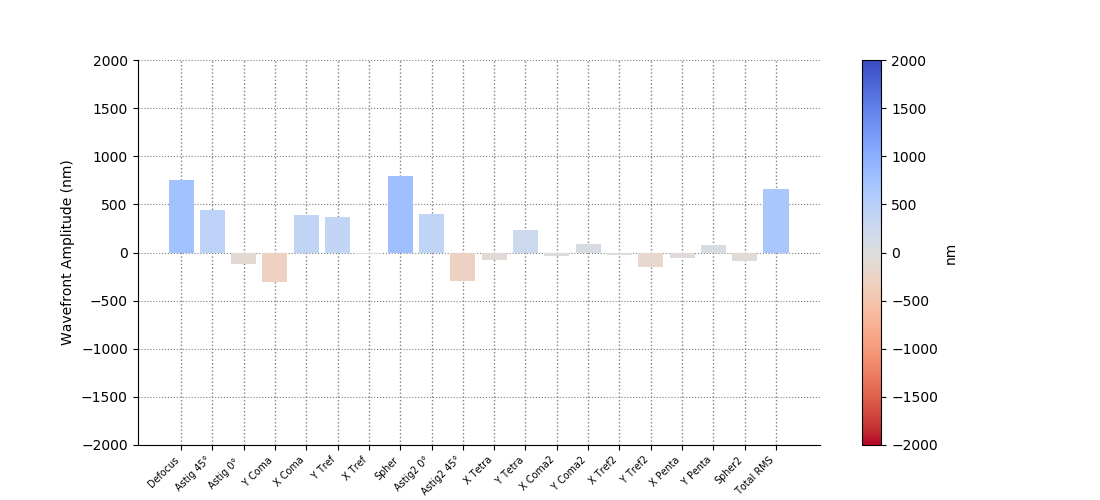

In [93]:
zv.fringe_bar_chart().show()

In [87]:
zv

Fringe Coefficients
 Z04:       756 nm 	 Defocus (2, 0)
 Z05:       446 nm 	 Primary Astig at 45° (2, -2)
 Z06:      -116 nm 	 Primary Astig at 0° (2, 2)
 Z07:      -304 nm 	 Primary Y Coma (3, -1)
 Z08:       390 nm 	 Primary X Coma (3, 1)
 Z09:       374 nm 	 Y Trefoil (3, -3)
 Z10:       -19 nm 	 X Trefoil (3, 3)
 Z11:       793 nm 	 Primary Spherical (4, 0)
 Z12:       402 nm 	 Secondary Astigmatism at 0° (4, 2)
 Z13:      -296 nm 	 Secondary Astigmatism at 45° (4, -2)
 Z14:     -74.2 nm 	 X Tetrafoil (4, 4)
 Z15:       237 nm 	 Y Tetrafoil (4, -4)
 Z16:     -38.4 nm 	 Secondary X Coma (5, 1)
 Z17:      85.9 nm 	 Secondary Y Coma (5, -1)
 Z18:     -27.7 nm 	 Secondary X Trefoil (5, 3)
 Z19:      -147 nm 	 Secondary Y Trefoil (5, -3)
 Z20:     -53.9 nm 	 X Pentafoil (5, 5)
 Z21:      81.8 nm 	 Y Pentafoil (5, -5)
 Z22:     -84.8 nm 	 Secondary Spherical (6, 0)

<IPython.core.display.Javascript object>


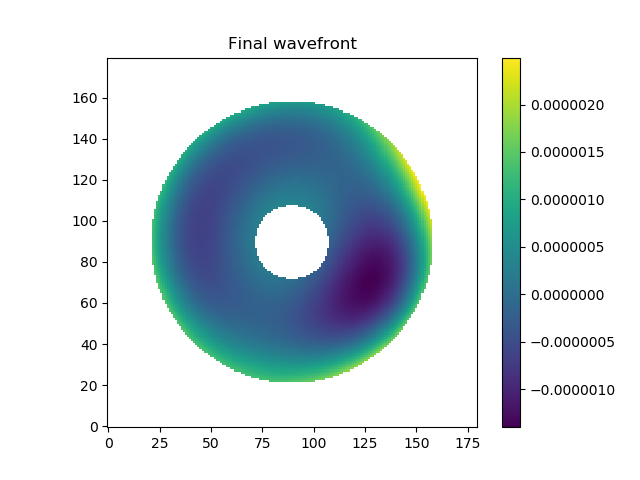

In [80]:
plots.plotImage(algo.Wconverge, "Final wavefront")

In [90]:
algo2 = Algorithm('fft', mmt, 3)
algo2.itr0(mmt, I1, I2, 'onAxis')

resetting images: I1 and I2
imageCoCenter: (x1,y1)=(   90.19,   90.05)

imageCoCenter: (x1,y1)=(   92.27,   89.71)

iOuter=0, cliplevel=0.33
(256, 256)
itr = 0, z4-z22
[ 229.  257.   36.  -92.   35.  207.  -27.  247.   52. -102.  -27.   89.
   31.   29.   13.  -38.    0.   25. -101.]


<IPython.core.display.Javascript object>


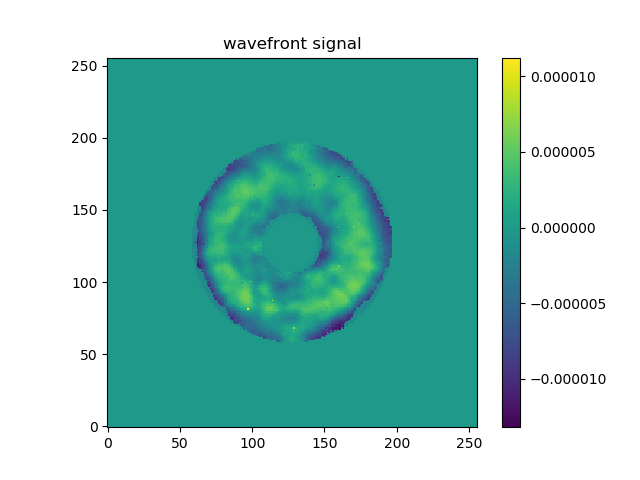

In [92]:
plots.plotImage(algo2.S, 'wavefront signal')